<a href="https://colab.research.google.com/github/sayakpaul/Handwriting-Recognizer-in-Keras/blob/main/Recognizer_KerasOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## References:
* https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_recognizer.html

## Initial setup

In [ ]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr
!pip install -U opencv-python # We need the most recent version of OpenCV.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import keras_ocr
import imgaug
import os

import tensorflow as tf
print(tf.__version__)
tf.random.set_seed(42)
np.random.seed(42)

2.4.0


In [ ]:
!nvidia-smi

Fri Jan 22 08:20:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Dataset gathering

In [ ]:
!wget -q https://pis-datasets.s3.us-east-2.amazonaws.com/IAM_Words.zip
!unzip -qq IAM_Words.zip

In [ ]:
!mkdir data
!mkdir data/words
!tar -C /content/data/words -xf IAM_Words/words.tgz
!mv IAM_Words/words.txt /content/data

In [ ]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


## Create training and validation splits

In [ ]:
words_list = []

words = open('/content/data/words.txt', 'r').readlines()
for line in words:
    if line[0]=='#':
        continue
    if line.split(" ")[1]!="err": # We won't need to deal with errored entries
        words_list.append(line)

len(words_list)

96456

In [ ]:
np.random.shuffle(words_list)
splitIdx = int(0.9 * len(words_list))
trainSamples = words_list[:splitIdx]
validationSamples = words_list[splitIdx:]

len(trainSamples), len(validationSamples)

(86810, 9646)

In [ ]:
def parse_path(file_line):
    lineSplit = file_line.strip()
    lineSplit = lineSplit.split(" ")
    # part1/part1-part2/part1-part2-part3.png
    imageName = lineSplit[0] 
    partI = imageName.split("-")[0]
    partII = imageName.split("-")[1]
    img_path =  os.path.join("/content/data/words/", partI, 
                (partI + '-' + partII),
                (imageName + ".png")
    )
    label = file_line.split(' ')[8:][0].strip() 
    if (os.path.getsize(img_path)!=0) & (label!=None):
        return (img_path, None, label.lower())

In [ ]:
train_labels = [parse_path(file_line) for file_line in trainSamples 
                if parse_path(file_line)!=None]
val_labels = [parse_path(file_line) for file_line in validationSamples 
              if parse_path(file_line)!=None]
len(train_labels), len(val_labels)

(86809, 9645)

In [ ]:
train_labels[:5]

[('/content/data/words/f02/f02-033/f02-033-00-02.png', None, 'do'),
 ('/content/data/words/n02/n02-049/n02-049-05-01.png', None, 'his'),
 ('/content/data/words/g05/g05-087/g05-087-02-04.png', None, 'evidently'),
 ('/content/data/words/h07/h07-025/h07-025-01-03.png', None, 'prime'),
 ('/content/data/words/n01/n01-031/n01-031-03-09.png', None, ';')]

## Create data generators

In [ ]:
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()

Looking for /root/.keras-ocr/crnn_kurapan.h5


In [ ]:
batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (val_labels, None)]     
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

12322 / 86809 instances have illegal characters.


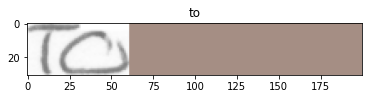

In [ ]:
image, text = next(training_image_gen)
plt.imshow(image)
plt.title(text)
plt.show()

[Here's](https://keras-ocr.readthedocs.io/en/latest/examples/end_to_end_training.html#generating-synthetic-data) where you can know on what basis a character is termed as illegal in the framework. 

## Model training and sample inference

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=True),
]
history = recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=1000
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
10851/10851 [==============================] - 765s 69ms/step - loss: 4.8348 - val_loss: 2.7913
Epoch 2/1000
10851/10851 [==============================] - 728s 67ms/step - loss: 2.7352 - val_loss: 2.3814
Epoch 3/1000
10851/10851 [==============================] - 703s 65ms/step - loss: 2.5155 - val_loss: 2.6978
Epoch 4/1000
10851/10851 [==============================] - 725s 67ms/step - loss: 5.8838 - val_loss: 2.4806
Epoch 5/1000
10851/10851 [==============================] - 718s 66ms/step - loss: 2.1935 - val_loss: 2.2792
Epoch 6/1000
10851/10851 [==============================] - 710s 65ms/step - loss: 2.1851 - val_loss: 2.2507
Epoch 7/1000
10851/10851 [==============================] - 700s 65ms/step - loss: 2.1589 - val_loss: 2.5480
Epoch 8/1000
10851/10851 [==============================] - 692s 64ms/step - loss: 2.2597 - val_loss: 2.5064
Epoch 9/1000
10851/10851 [==============================] - 706s 65ms/step - loss: 2.3399 - val_loss: 3.0601
Epoch 10/1000
10851

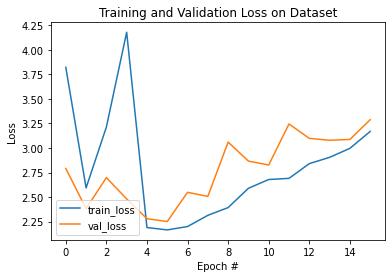

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.show()

The training seems to be a bit unstable. This can likely be mitigated by using a lower learning rate. 

Predicted: and, Actual: and


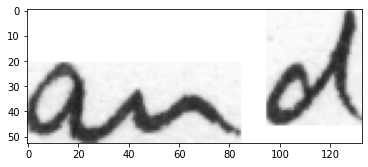

In [ ]:
image_filepath, _, actual = val_labels[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))